In [1]:
from torchvision.models import ResNet18_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
# Paths to the dataset
data_dir = '/kaggle/input/cats-vs-dogs-dataset/cats_and_dogs_small'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
print("Number of training samples:", len(train_dataset))# 1000 dogs and 1000 cats
print("Number of validation samples:", len(valid_dataset))# 500 dogs and 500 cats
print("Number of test samples:", len(test_dataset))# 500 dogs and 500 cats
print("Classes:", train_dataset.classes)

Number of training samples: 2000
Number of validation samples: 1000
Number of test samples: 1000
Classes: ['cats', 'dogs']


In [6]:
# Load the ResNet18 model with weights
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two output classes: cat and dog

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [7]:
#Train model
def train_model(model, criterion, optimizer, num_epochs=1):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0  # Track total number of samples processed

        # Training progress bar
        progress_bar = tqdm(train_loader, desc="Training Progress")
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass + optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update progress bar with train loss and accuracy
            progress_bar.set_postfix({
                'Train loss': running_loss / total_samples,
                'Train Accuracy': running_corrects.double() / total_samples
            })

        # Final training loss and accuracy for the epoch
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Validation progress bar
        progress_bar = tqdm(valid_loader, desc="Validation Progress")
        with torch.no_grad():  # Disable gradient calculation during validation
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                # Update progress bar with validation loss and accuracy
                progress_bar.set_postfix({
                    'Validation Loss': running_loss / total_samples,
                    'Validation Accuracy': running_corrects.double() / total_samples
                })

        # Final validation loss and accuracy for the epoch
        val_loss = running_loss / len(valid_dataset)
        val_acc = running_corrects.double() / len(valid_dataset)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f} Validation Accuracy: {val_acc:.4f}")

        print()

    return train_losses, val_losses

    print("Training complete")

# Train the model
train_losses, val_losses =train_model(model, criterion, optimizer, num_epochs=5)


Epoch 1/5
----------


Training Progress: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s, Train loss=0.396, Train Accuracy=tensor(0.8430, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.3963 Train Accuracy: 0.8430


Validation Progress: 100%|██████████| 32/32 [00:06<00:00,  5.25it/s, Validation Loss=0.201, Validation Accuracy=tensor(0.9060, device='cuda:0', dtype=torch.float64)]


Validation Loss: 0.2013 Validation Accuracy: 0.9060

Epoch 2/5
----------


Training Progress: 100%|██████████| 63/63 [00:09<00:00,  6.41it/s, Train loss=0.175, Train Accuracy=tensor(0.9315, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.1746 Train Accuracy: 0.9315


Validation Progress: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s, Validation Loss=0.332, Validation Accuracy=tensor(0.8200, device='cuda:0', dtype=torch.float64)]


Validation Loss: 0.3318 Validation Accuracy: 0.8200

Epoch 3/5
----------


Training Progress: 100%|██████████| 63/63 [00:09<00:00,  6.52it/s, Train loss=0.14, Train Accuracy=tensor(0.9460, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.1395 Train Accuracy: 0.9460


Validation Progress: 100%|██████████| 32/32 [00:03<00:00,  8.20it/s, Validation Loss=0.14, Validation Accuracy=tensor(0.9440, device='cuda:0', dtype=torch.float64)]


Validation Loss: 0.1402 Validation Accuracy: 0.9440

Epoch 4/5
----------


Training Progress: 100%|██████████| 63/63 [00:09<00:00,  6.61it/s, Train loss=0.0828, Train Accuracy=tensor(0.9670, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.0828 Train Accuracy: 0.9670


Validation Progress: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s, Validation Loss=0.262, Validation Accuracy=tensor(0.8940, device='cuda:0', dtype=torch.float64)]


Validation Loss: 0.2617 Validation Accuracy: 0.8940

Epoch 5/5
----------


Training Progress: 100%|██████████| 63/63 [00:09<00:00,  6.58it/s, Train loss=0.116, Train Accuracy=tensor(0.9560, device='cuda:0', dtype=torch.float64)]


Train Loss: 0.1160 Train Accuracy: 0.9560


Validation Progress: 100%|██████████| 32/32 [00:03<00:00,  8.68it/s, Validation Loss=0.237, Validation Accuracy=tensor(0.8980, device='cuda:0', dtype=torch.float64)]

Validation Loss: 0.2372 Validation Accuracy: 0.8980



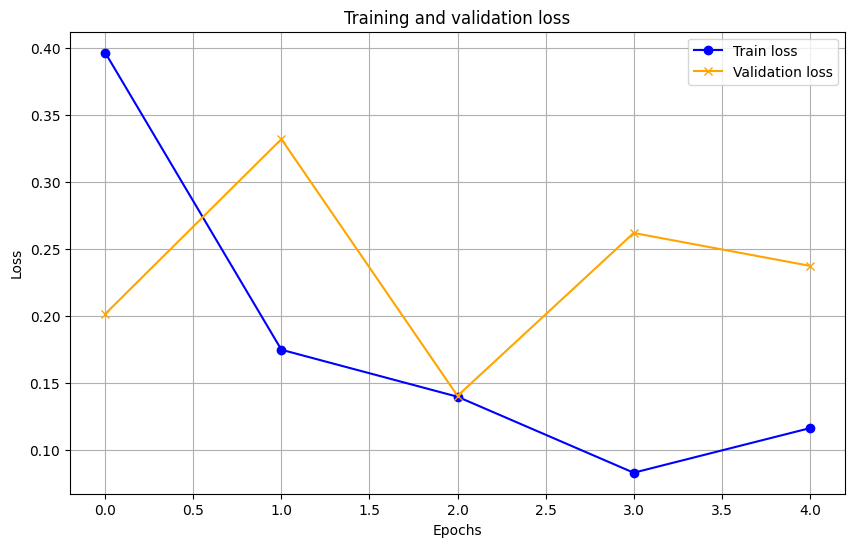

In [8]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot( train_losses, label='Train loss', color='blue', marker='o')
plt.plot( val_losses, label='Validation loss', color='orange', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

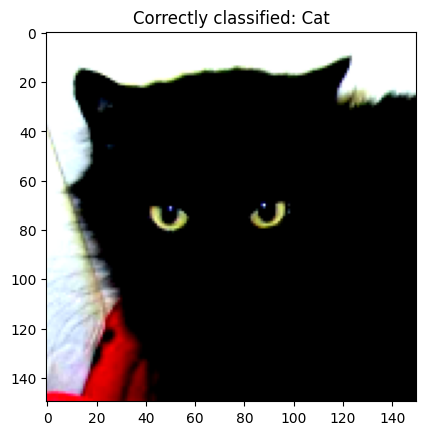

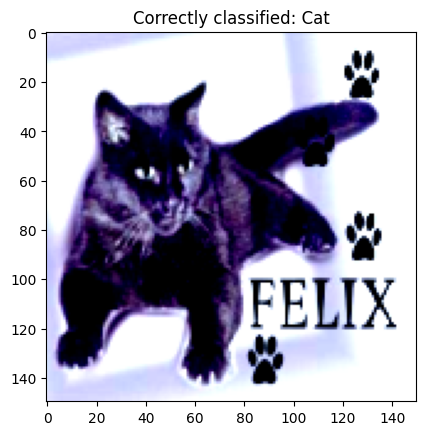

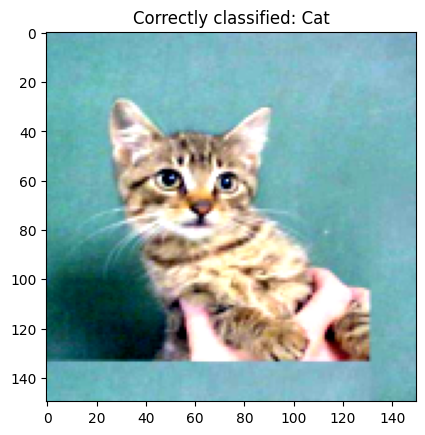

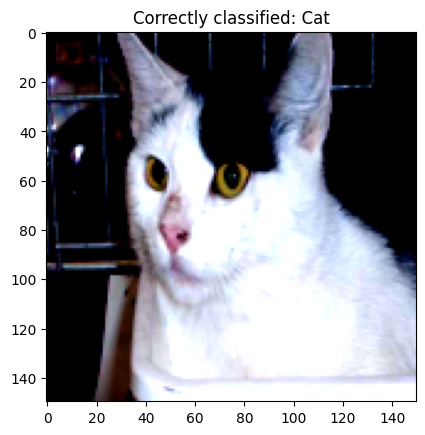

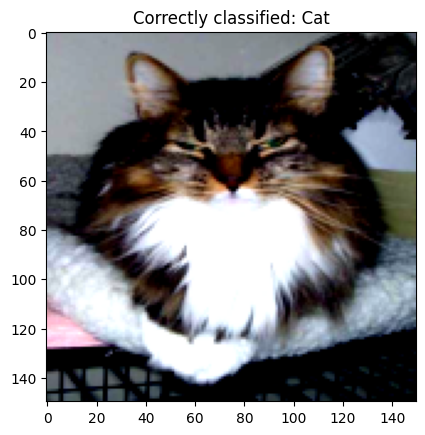

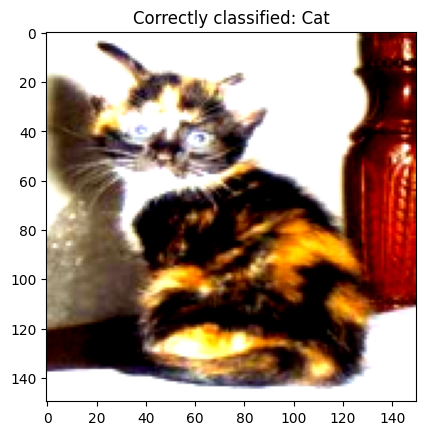

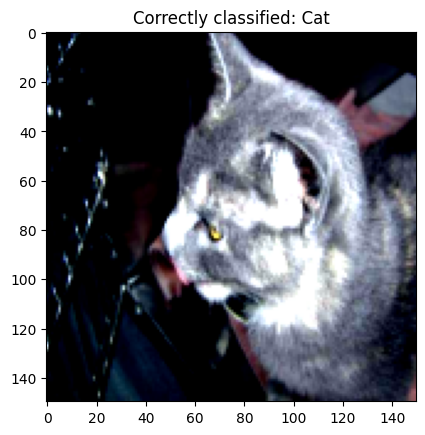

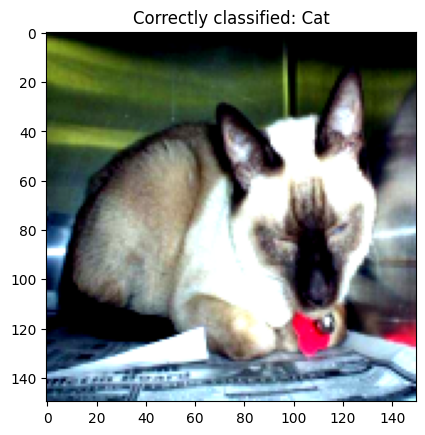

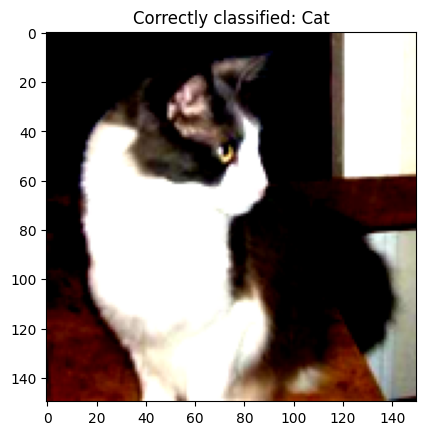

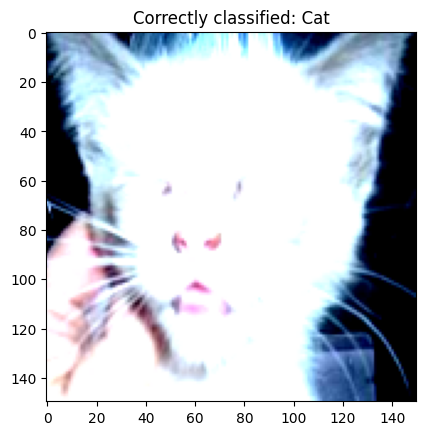

In [9]:
# Few correctly classified images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

# List to store correctly classified images and labels
correctly_classified_images = []
correctly_classified_labels = []

# Loop over the test data and collect correctly classified examples
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect correctly classified images and labels
        for i in range(len(preds)):
            if preds[i] == labels[i]:  # Check if the prediction is correct
                correctly_classified_images.append(inputs[i].cpu())  # Move tensor to CPU for display
                correctly_classified_labels.append(preds[i].item())  # Store the predicted label

# Visualize the first 10 correctly classified images
for i in range(min(len(correctly_classified_images), 10)):
    label = 'Dog' if correctly_classified_labels[i] == 1 else 'Cat'
    title = f"Correctly classified: {label}"
    imshow(correctly_classified_images[i], title)